In [76]:
# text manipulation
import re
import string

# Data management
import pandas as pd
import numpy as np
from scipy.sparse import *
import scipy

# NLP
import nltk
import nltk.collocations as collocations
from nltk.tag import tnt
import spacy

# modelling
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import f1_score, confusion_matrix

#visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style 

%matplotlib inline

In [2]:
train = pd.read_csv('./train.csv')

In [3]:
no_insincere = train[train['target']==1].target.count()
no_sincere = train[train['target']==0].target.count()

print('No. of insincere questions:', no_insincere)
print('No. of sincere questions:', no_sincere)
print('% of insincere questions:', train.target.mean())
print('Null score:', 1- train.target.mean())

No. of insincere questions: 80810
No. of sincere questions: 1225312
% of insincere questions: 0.06187017751787352
Null score: 0.9381298224821265


# Define functions and pipelines

In [4]:
def vect_trans(vectorizer, X_train, X_test):
    # can also take a transformer
    vect = vectorizer
    vect.fit(X_train)
    return vect.transform(X_train), vect.transform(X_test)

In [5]:
# MultinominalNB function for printing scores and storing into df.
def model_score(model, X_train, X_test, y_train, y_test, score_df, model_label):
    estimator = model
    estimator.fit(X_train, y_train)
    test_score =  estimator.score(X_test, y_test)
    f1 = f1_score(y_test, estimator.predict(X_test))
    
    print('Train Accuracy :', estimator.score(X_train, y_train))
    print('Test Accuracy:', test_score)
    print('Test F1 score:', f1)
    score_df.loc[model_label, 'Test_Accuracy'] = test_score
    score_df.loc[model_label, 'Test_F1_score'] = f1

In [6]:
# Cross Validate function for printing scores and storing into df.
def cv_score(model, X, y, model_label,  cv=5, ):    
    
    # instantiating model
    estimator = model
    
    cv_result = cross_validate(estimator, X, y, cv = cv, n_jobs=-1, scoring=['accuracy', 'f1'])
    
    print('Test Accuracy Mean:',cv_result['test_accuracy'].mean())
    print('Test Accuracy STD:',cv_result['test_accuracy'].std())
    print('Test F1:', cv_result['test_f1'].mean())
    score_df.loc[model_label, 'CV_Accuracy'] = cv_result['test_accuracy'].mean()
    score_df.loc[model_label, 'CV_Acc_STD'] = cv_result['test_accuracy'].std()
    score_df.loc[model_label, 'CV_F1_score'] = cv_result['test_f1'].mean()

In [7]:
# GridSearchCV function, auto display best score and parameters and storing in df
def gridcv(model, X, y, params, cv= 5 ):
    
    # instantiating model can also be a pipeline
    estimator = model
    
    gridcv = GridSearchCV(estimator=estimator, param_grid=params, cv = cv, verbose=10, n_jobs=6)
    gridcv.fit(X, y)
    
    print(gridcv.best_params_)
    print(gridcv.best_score_)
    

In [10]:
# CountVectorizer pipeline and parameters
pipeCVNB = Pipeline([('CV',CountVectorizer(stop_words=stopwords)), 
                    ('NB',MultinomialNB())])

paramsCVNB = {'CV__max_df':(1.0, 0.9, 0.8, 0.7),
       'CV__min_df': (1, 2, 0.01 , 0.1, 0.2),
         'CV__ngram_range':((1,1), (1,2), (1,3))}

In [11]:
# TfidfVectorizer pipeline and parameters
pipeTVNB = Pipeline([('TV',TfidfVectorizer(stop_words=stopwords)), 
                    ('NB',MultinomialNB())])

paramsTVNB = {'TV__max_df':(1.0, 0.9, 0.8, 0.7, 0.6),
       'TV__min_df': (1, 2, 0.01, 0.05, 0.1),
         'TV__ngram_range':((1,1), (1,2), (1,3), (2,2), (2,3))}

In [12]:
score_df = pd.DataFrame()

# Lemmatization

In [80]:
%%time
clean_questions = (re.sub("[^A-Za-z']+", ' ', q).lower() for q in train['question_text'])

Wall time: 48 ms


In [85]:
# using spaCy to lemmatize using POS tags in one step, with out converting between WordNet and Treebank tags, using NLTK
spac = spacy.load('en', disable=['parser', 'ner'])
def lemmatizer(text):
    text = spac(text)
    return ' '.join([token.lemma_ for token in text if token.lemma_ not in stopwords])

In [ ]:
%%time
lemma_q = [lemmatizer(q) for q in train.question_text]

In [ ]:
lemma_train = pd.DataFrame(lemma_q, columns = ['question_text'])
lemma_train['target'] = train.target
lemma_train.head()

In [ ]:
lemma_train.to_pickle('./lemma_train.pkl')

In [13]:
lemma_train = pd.read_pickle('./lemma_train.pkl')

In [ ]:
stopwords = list(nltk.corpus.stopwords.words('english')) + list(string.punctuation) + ["''", '``','’','“','”', "'s", "'d", "'ll", "'t", "n't", "ca", 'wo']

In [ ]:
%%time
# remove stop words and lower all characters
clean_questions = [' '.join(w for w in nltk.word_tokenize(q.lower()) if w not in stopwords) for q in clean_questions]

In [ ]:
# replacing all identity labels each question with a common labels
def labels_to_question(data, label_list, label_type):
         
    new_data = []
    
    # For every questions
    i_data = 0
    for i_data in range(len(data)):
        question = data[i_data].lower()
        output = []
        
        # compare each label to question
        for label in label_list:

            if label in question:

                que_t = nltk.word_tokenize(question)
                lab_t = nltk.word_tokenize(label)

                i_que = 0
                while i_que < len(que_t):
                    i_lab = 0
                    
                    # If current token is same as first label token, continue compare rest of the tokens. 
                    if que_t[i_que] == lab_t[0]:
                        que_t[i_que] = label_type
                        i_lab += 1
                        i_que += 1

                        # Remove trailing question tokens if they match trailing label tokens
                        while i_lab < len(lab_t):
                            if que_t[i_que] == lab_t[i_lab]:
                                que_t.pop(i_que)
                                i_lab += 1
                            else:
                                break
#                     elif que_t[i_que] == lab_t[0]:
#                         print('Question: ',question, i_data)
#                         print('label: ', label)
                    i_que += 1
                question = ' '.join(que_t)
#                 print('after: ', question)
#                 print('label: ', label)
        new_data.append(question)                   
        if i_data % 1000 == 0:
            clear_output(wait=True)
            display(i_data)
    return new_data


In [ ]:
# Identity groupd filters, created from online lists, most frequent insincere words and manual editing.
ID_filter = pd.read_csv('ID_filter.csv')

In [ ]:
ID_filter.head(2)

In [ ]:
# religious_ID = ID_filter.RELIGIOUS_ID.dropna()
# racial_ID = ID_filter.RACIAL_ID.dropna()
# national_ID = ID_filter.NATIONAL_ID.dropna()
# nationality_ID = ID_filter.NATIONALITY_ID.dropna()



In [ ]:
# %%time
# clean_questions = labels_to_question(clean_questions, religious_ID, 'RELIGIOUS_ID')
# clean_questions = labels_to_question(clean_questions, racial_ID, 'RACIAL_ID')
# clean_questions = labels_to_question(clean_questions, national_ID, 'NATIONAL_ID')
# clean_questions = labels_to_question(clean_questions, nationality_ID, 'NATIONALITY_ID')

In [ ]:
X = clean_questions
y = lemma_train.target

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 495)

# Default count vectorizer on raw text

In [ ]:
%%time

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(train.question_text, train.target,
                                                                    stratify=train.target, random_state = 495)

X_train_raw_t, X_test_raw_t=  vect_trans(CountVectorizer(), X_train_raw, X_test_raw)

In [ ]:
model = MultinomialNB()
model_label = 'Raw_token_NB'

model_score(model, X_train_raw_t, X_test_raw_t, y_train_raw, y_test_raw, score_df, model_label)
cv_score(model, X_train_raw_t, y_train_raw, model_label)
score_df

In [ ]:
nb = MultinomialNB()
nb.fit(X_train_raw_t, y_train_raw)  
test_score =  nb.score(X_test_raw_t, y_test_raw)
print('train score:', nb.score(X_train_raw_t, y_train_raw))
print('test score:', test_score)
y_pred = nb.predict(X_test_raw_t)

In [ ]:
print(f1_score(y_test_raw, y_pred) )
print(f1_score(y_test_raw, y_pred, average='macro') )
print(f1_score(y_test_raw, y_pred, average='micro') )
print(f1_score(y_test_raw, y_pred, average='weighted') )
confusion_matrix(y_test_raw, y_pred)

# Basic Token and Ngram modelling on cleaned data

Creating train/test sets

In [ ]:
X = clean_questions
y = train.target

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 495)

### Tokens only

In [ ]:
%%time
X_train_t, X_test_t=  vect_trans(CountVectorizer(max_df=1.0, min_df=1, ngram_range=(1,1)), X_train, X_test)

In [ ]:
model = MultinomialNB()
model_label = 'Token_NB'
X_train_arg = X_train_t
X_test_arg = X_test_t

model_score(model, X_train_arg, X_test_arg, y_train, y_test, score_df, model_label)
cv_score(model, X_train_arg, y_train, model_label)
score_df

### All Bigrams

In [ ]:
%%time
X_train_bi, X_test_bi=  vect_trans(CountVectorizer(ngram_range=(1,2)), X_train, X_test)

Naive Bayes

In [ ]:
model = MultinomialNB()
model_label = 'Bigram_NB'
X_train_arg = X_train_bi
X_test_arg = X_test_bi

model_score(model, X_train_arg, X_test_arg, y_train, y_test, score_df, model_label)
cv_score(model, X_train_arg, y_train, model_label)
score_df

Random Forest

In [ ]:
# %%time
# model = RandomForestClassifier(n_estimators= 100, max_depth=20, n_jobs=-1)
# model_label = 'Bigram_RF'


# model_score(model, X_train_bi, X_test_bi, y_train, y_test, score_df, model_label)
# cv_score(model, X_train_bi, y_train, model_label)
# score_df

In [ ]:
# score_df

### Tri-gram

In [ ]:
%%time
X_train_tri, X_test_tri=  vect_trans(CountVectorizer(ngram_range=(1,3), stop_words=stopwords), X_train, X_test)

Naive Bayes

In [ ]:
model = MultinomialNB()
model_label = 'Trigram_NB'
X_train_arg = X_train_tri
X_test_arg = X_test_tri

model_score(model, X_train_arg, X_test_arg, y_train, y_test, score_df, model_label)
cv_score(model, X_train_arg, y_train, model_label)
score_df

Random Forest

In [ ]:
# %%time
# model = RandomForestClassifier(n_estimators= 100, max_depth=20, n_jobs=-1)
# model_label = 'Trigram_RF'

# model_score(model, X_train_tri, X_test_tri, y_train, y_test, score_df, model_label)
# cv_score(model, X_train_tri, y_train, model_label)


In [ ]:
# score_df

### GridSearch min/max df

In [ ]:
# params = {'CV__max_df':(1.0, 0.9),
#        'CV__min_df': (1, 2, 0.01, 0.02),
#         'CV__ngram_range':((1,1), (1,2), (1,3))}

# gridcv(pipeCVNB, X_train, y_train, params)

In [ ]:
# %%time
# X_train_t, X_test_t=  vect_trans(CountVectorizer(max_df=1.0, min_df=1, ngram_range=(1,2), 
#                                                     stop_words=stopwords), X_train, X_test)

In [ ]:
# model = MultinomialNB()
# model_label = 'Grid_DFNB'

# model_score(model, X_train_t, X_test_t, y_train, y_test, score_df, model_label)
# cv_score(model, X_train_t, y_train, model_label)
# score_df

### TFIDF

In [ ]:
X_train_tf_t, X_test_tf_t = vect_trans(TfidfTransformer(), X_train_t, X_test_t)

In [ ]:
model = MultinomialNB()
model_label = 'Tfidf_t_NB'

model_score(model, X_train_tf_t , X_test_tf_t, y_train, y_test, score_df, model_label)
cv_score(model, X_train_tf_t, y_train, model_label)
score_df

In [ ]:
nb = MultinomialNB()
nb.fit(X_train_tf_t, y_train)  
test_score =  nb.score(X_test_tf_t, y_test)
print('train score:', nb.score(X_train_tf_t, y_train))
print('test score:', test_score)
y_pred = nb.predict(X_test_tf_t)

In [ ]:
print(f1_score(y_test, y_pred) )
print(f1_score(y_test, y_pred, average='macro') )
print(f1_score(y_test, y_pred, average='micro') )
print(f1_score(y_test, y_pred, average='weighted') )
confusion_matrix(y_test, y_pred)

### NLTK Best Bigrams

In [ ]:
# recreate text using ngrams
def ngram_to_corpus(data, ngram_list, n):
#     ngram_list = set({('let', 'us'), ('as', 'soon')})  # {('let', 'us'), ('as', 'soon')}
#     tokens = ['please', 'let', 'us', 'know', 'as', 'soon', 'as', 'possible']
    new_data = []
    for text in data:
        tokens = nltk.word_tokenize(text)
        output = []
        q_iter = iter(range(len(tokens)))
        
        for idx in q_iter:
            output.append(tokens[idx])
            if n == 2:
                if idx < (len(tokens) - 1) and (tokens[idx], tokens[idx+1]) in ngram_list:
                    output[-1] += '_' + tokens[idx+1]
                    next(q_iter)
            elif n == 3:
                if idx < (len(tokens) - 2) and (tokens[idx], tokens[idx+1], tokens[idx+2] ) in ngram_list:
                    output[-1] += '_' + tokens[idx+1] + '_' + tokens[idx+2]
                    next(q_iter)
                    next(q_iter)
        new_data.append( ' '.join(output))

    return new_data

In [ ]:
%%time
# create one list of all question tokens
full_text = []

for text in X_train:
    full_text += [w for w in nltk.word_tokenize(text) if w not in stopwords]

In [ ]:
len(full_text)

In [ ]:
if 'would' in stopwords:
    print(True)

In [ ]:
%%time
# create bigram vocabulary
bigram_measures = collocations.BigramAssocMeasures()

finder = nltk.BigramCollocationFinder.from_words(full_text)
# scored = finder.score_ngrams( bigram_measures.likelihood_ratio  )
bigram_vocab = finder.nbest(bigram_measures.likelihood_ratio, 80)
print(bigram_vocab)

In [ ]:
%%time
# create bigram vocabulary
bigram_measures = collocations.BigramAssocMeasures()


finder3 = nltk.BigramCollocationFinder.from_words(full_text)
finder3.apply_freq_filter(10)
finder3.apply_word_filter(lambda x: x in stopwords)
best_pmi = finder3.nbest(bigram_measures.pmi, 200)
print(best_pmi)

In [ ]:
%%time
# create trigram vocabulary
trigram_measures = collocations.TrigramAssocMeasures()
finder = nltk.TrigramCollocationFinder.from_words(full_text)
trigram_vocab = finder.nbest(trigram_measures.likelihood_ratio, 20)
print(trigram_vocab)

In [ ]:
%%time
# create text with bigram replacement
train['bigram_question_lkhd'] = ngram_to_corpus(clean_questions, bigram_vocab, 2)

In [ ]:
%%time
# create text with both tri and bigram in text, by applying trigram first
train['trigram_question_lkhd'] = ngram_to_corpus(clean_questions, trigram_vocab, 3)
train['trigram_question_lkhd'] = ngram_to_corpus(train['trigram_question_lkhd'], bigram_vocab, 2)

In [ ]:
train['trigram_question_lkhd'][20:25].values

In [ ]:
X = train[['bigram_question_lkhd','trigram_question_lkhd']]
y = train.target

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=495, test_size=0.2)

In [ ]:
len(X_train)

In [ ]:
X_train.head()

#### Bigram Model

In [ ]:
# model using bigram text
X_train_bi, X_test_bi =  vect_trans(CountVectorizer(max_df=1.0,  min_df=1, ngram_range=(1,1), stop_words=stopwords),
                                   X_train.bigram_question_lkhd, X_test.bigram_question_lkhd,)



In [ ]:
model = MultinomialNB()
model_label = 'Bigram_best_NB'

model_score(model, X_train_bi, X_test_bi, y_train, y_test, score_df, model_label)
cv_score(model, X_train_bi, y_train, model_label)
score_df

#### Trigram Model

In [ ]:
# model using bigram text
X_train_tri, X_test_tri =  vect_trans(CountVectorizer(max_df=1.0,  min_df=1, ngram_range=(1,1), stop_words=stopwords),
                                   X_train.trigram_question_lkhd, X_test.trigram_question_lkhd)



In [ ]:
model = MultinomialNB()
model_label = 'Trigram_best_NB'

model_score(model, X_train_tri, X_test_tri, y_train, y_test, score_df, model_label)
cv_score(model, X_train_tri, y_train, model_label)
score_df

In [ ]:
score_df.to_pickle('./lemma1_score.pkl')

In [72]:
score_df = pd.read_pickle('./lemma_score.pkl')

### Visualisation

In [73]:
acc_df = pd.DataFrame(index=['Baseline','Raw Token', 'Tokens', 'All Bigram', 'All Trigram', 'TFIDF', 'N Bigram', 'N Trigram'])
acc_df['Accuracy'] = acc_list = [1-train.target.mean()] + list(score_df['Test_Accuracy'][:7])


In [74]:
f1_df =  pd.DataFrame(index=['Raw Token', 'Tokens', 'All Bigram', 'All Trigram', 'TFIDF', 'N Bigram', 'N Trigram'])
f1_df['F1 Score'] = list(score_df['Test_F1_score'][:7])


In [77]:
style.use('seaborn-poster')

style.use('seaborn-whitegrid') #sets the size of the charts
style.use('tableau-colorblind10')

In [78]:
f1_hue = sns.color_palette("Set3")
acc_hue  = sns.color_palette("Set3")
acc_hue.insert(0, (.7,.7,.7))

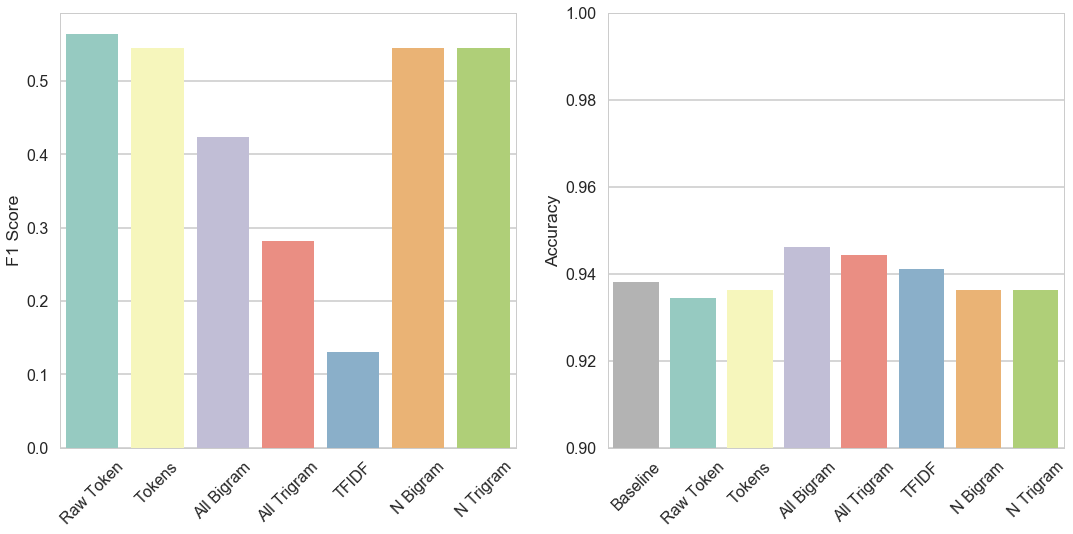

In [79]:
fig, ax = plt.subplots(1,2, figsize=(18,8))

ax1 = plt.subplot(121)
ax1 = sns.barplot(x=f1_df.index, y=f1_df['F1 Score'], palette=f1_hue)
ax1 = plt.xticks(rotation=45)

ax2 = plt.subplot(122)
ax2 = sns.barplot(x=acc_df.index, y=acc_df.Accuracy, palette=acc_hue)
ax1 = plt.ylim(0.9, 1)
ax2 = plt.xticks(rotation=45)


